# Demand forecasting with the Temporal Fusion Transformer


In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split
import random
import matplotlib.pyplot as plt

In [5]:
path = os.getcwd() + '/docs/source/tutorials/project_data/'

### ML models

In [7]:
df = pd.read_csv(path+'230609.csv', index_col=0)
df.drop(['time_idx', 'time_range', 'dawn', 'day', 'night', 'hour'], axis=1, inplace=True)

In [23]:
df.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

X = df.drop(['% Iron Concentrate', '% Silica Concentrate'], axis=1)
y = df['% Silica Concentrate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_norm = StandardScaler().fit_transform(X_train)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Square Error:", mse)
print("Mean Absolute Error:", mae)

Mean Square Error: 0.9912004096021484
Mean Absolute Error: 0.7889986169986706


In [32]:
def model_trainval(model, x, y):
    
    scoring = ['neg_mean_absolute_error', 'r2']
    scores = cross_validate(model, x, y, scoring=scoring)
    MAE = -scores['test_neg_mean_absolute_error'].mean()
    R2 = scores['test_r2'].mean()
    print(f"Result of Model {model} Validation")
    print(f"MAE: {MAE}")
    print(f"R2: {R2}")
    
    return MAE, R2

In [33]:
reg0=LinearRegression()
[MAE, R2]=model_trainval(reg0,X_train_norm, y_train)

MAE_Col=[]
R2_Col=[]

MAE_Col.append(MAE)
R2_Col.append(R2)

Result of Model LinearRegression() Validation
MAE: 0.7950052652450095
R2: 0.2043319568706406


In [34]:
from sklearn.ensemble import RandomForestRegressor

reg3=RandomForestRegressor(max_depth=10,n_estimators=10)

[MAE,R2]=model_trainval(reg3, X_train_norm,y_train)

MAE_Col.append(MAE)
R2_Col.append(R2)

Result of Model RandomForestRegressor(max_depth=10, n_estimators=10) Validation
MAE: 0.5992474215173234
R2: 0.48585774243017654


### ANN

In [35]:
class Dataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.X = self.df.drop(['% Silica Concentrate', '% Iron Concentrate'], axis=1).to_numpy()
        self.X = self.scaler.fit_transform(self.X)
        self.y = list(self.df['% Silica Concentrate'])        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.X[idx])
        y = torch.FloatTensor([self.y[idx]])
        return x, y

In [36]:
df = Dataset(df)
df.__getitem__(0)

(tensor([ 0.1406, -0.2327, -0.6823,  0.0807,  0.3940, -0.3444,  1.0818, -1.3991,
         -1.2009, -1.5013, -2.4301,  2.7673, -1.7237, -1.8395,  1.7550,  1.8354,
          1.3696,  0.4253,  0.3809,  0.3187,  0.4302]),
 tensor([1.4300]))

In [37]:
class ANN(nn.Module):
    def __init__(self, input_dim, h1, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h1, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [40]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
train_size = int(0.7 * len(df))
test_size = len(df) - train_size
trainset, testset = random_split(df, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)
                        
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = ANN(df.X.shape[1], 64, 1).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 500

loss_per_batch = []

In [41]:
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.type(torch.Tensor) 
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_per_batch.append(running_loss / (i + 1))
    temp = running_loss
    running_loss = 0.0

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.type(torch.Tensor).to(device)
            outputs = model(inputs.float())
    
    if epoch % 20 == 0:
        print(f'{epoch} starts')
        print(f'running_loss {temp}')
        print(f'Test loss: {torch.mean(torch.abs(outputs.data - labels))}')

0 starts
running_loss 55.284516632556915
Test loss: 0.7089241743087769
20 starts
running_loss 37.696012914180756
Test loss: 0.629736602306366
40 starts
running_loss 35.593902349472046
Test loss: 0.6235107183456421
60 starts
running_loss 34.93835148215294
Test loss: 0.5930328369140625
80 starts
running_loss 34.0840722322464
Test loss: 0.5978537201881409
100 starts
running_loss 33.41334709525108
Test loss: 0.5743963122367859
120 starts
running_loss 33.42443659901619
Test loss: 0.560070812702179
140 starts
running_loss 32.76787328720093
Test loss: 0.540773868560791
160 starts
running_loss 32.435328274965286
Test loss: 0.5547834634780884
180 starts
running_loss 32.083720564842224
Test loss: 0.544905424118042
200 starts
running_loss 32.26098519563675
Test loss: 0.520087718963623
220 starts
running_loss 31.905545741319656
Test loss: 0.5418147444725037
240 starts
running_loss 32.005396246910095
Test loss: 0.5508986115455627
260 starts
running_loss 31.66094398498535
Test loss: 0.55196046829223

KeyboardInterrupt: 

### TFT

In [6]:
data = pd.read_csv(path+'new.csv', index_col=0, parse_dates=['date'], infer_datetime_format=True, decimal=',' ).reset_index(drop=True)

In [11]:
ttt = pd.read_csv(path+'230609.csv', index_col=0)

In [16]:
len(ttt.columns[:-4])

25

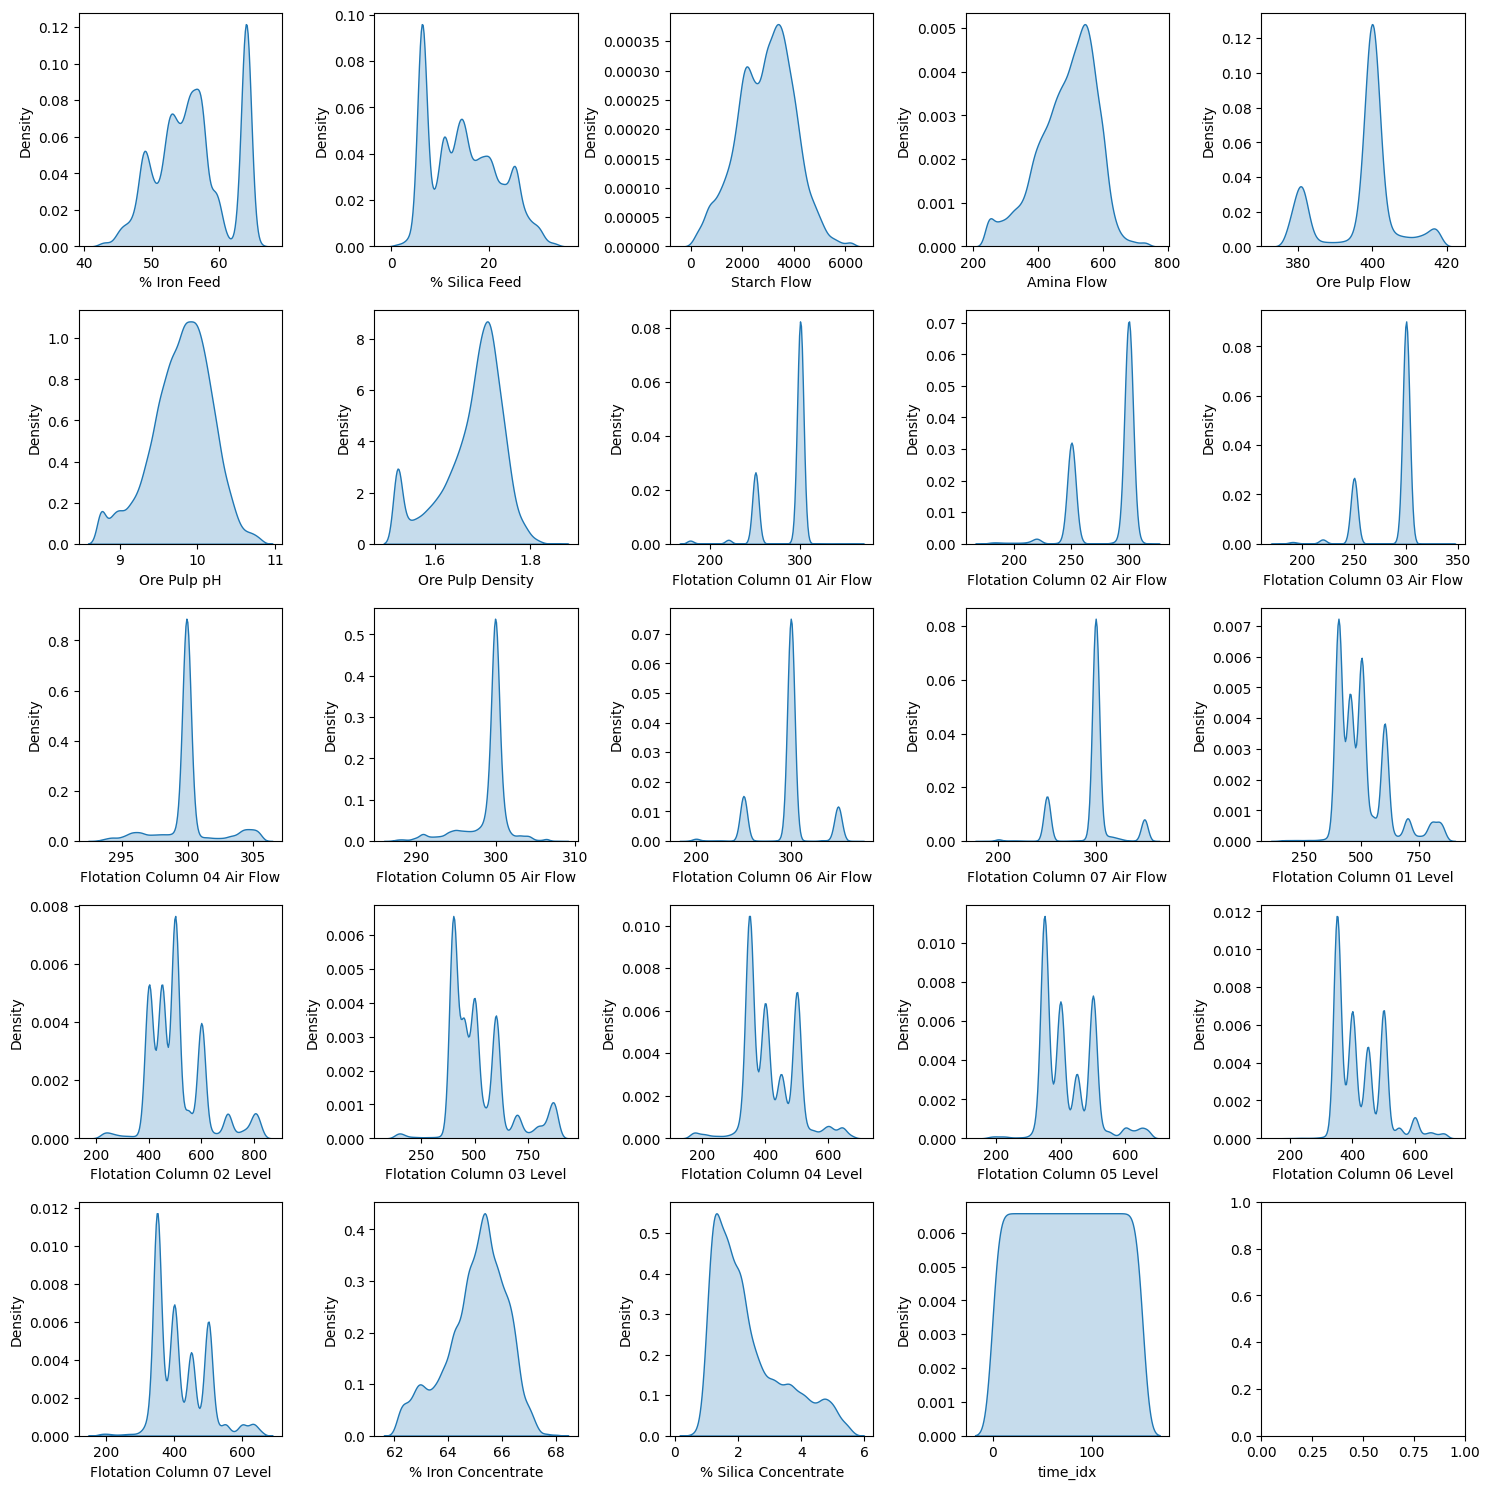

In [22]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(ttt.columns[:-4]):
    try:
        sns.kdeplot(data=ttt[column], shade=True, ax=axes[i])
        axes[i].set_xlabel(column)
    except:
        continue

for j in range(25, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [6]:
data['date_temp'] = data['date'].dt.strftime('%Y-%m-%d')
data["time_idx"] = data["date_temp"].astype(str).astype("category").cat.codes
data['batch'] = (data.index // 30) + 1
data = data.groupby('batch').mean().reset_index(drop=True)

In [7]:
data['time_range'] = (['dawn']*24 + ['day']*24 + ['night']*24) * 304
temp = pd.get_dummies(data['time_range'])
data = pd.concat([data, temp], axis=1)
time_range = ['dawn', 'day', 'night']
data[time_range] = data[time_range].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data['time_idx'] = data['time_idx'].astype('int')
data['hour'] = [i for i in range(24) for _ in range(6)] * 152

In [9]:
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,time_idx,time_range,dawn,day,night,hour
0,56.90,13.27,2188.172667,496.410433,400.979500,9.656423,1.748558,249.375633,250.348200,249.964633,...,449.743700,449.483467,65.77,1.43,0,dawn,dawn,-,-,0
1,56.90,13.27,2246.475667,495.634233,400.291533,9.667804,1.753257,249.868133,249.040433,250.053367,...,453.563433,451.585900,65.77,1.43,0,dawn,dawn,-,-,0
2,56.90,13.27,2475.248333,502.428933,400.377700,9.715140,1.757305,250.273500,249.759633,250.299933,...,451.608367,453.117867,65.77,1.43,0,dawn,dawn,-,-,0
3,56.90,13.27,2291.417667,501.038067,395.883467,9.758797,1.763687,250.081533,250.211900,250.293367,...,450.546067,453.716600,65.77,1.43,0,dawn,dawn,-,-,0
4,56.90,13.27,2067.281000,489.734600,401.647467,9.746133,1.762028,250.064600,249.117100,250.051367,...,446.797833,441.841933,65.77,1.43,0,dawn,dawn,-,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21883,49.75,23.20,4067.137000,454.760300,380.728578,9.670436,1.675748,299.134467,299.967633,299.752200,...,400.379267,398.043367,64.27,1.71,151,night,-,-,night,23
21884,49.75,23.20,4627.553667,452.789033,380.941306,9.684356,1.668100,299.398267,300.473267,299.590367,...,400.798467,399.840200,64.27,1.71,151,night,-,-,night,23
21885,49.75,23.20,3541.358917,469.458333,380.028483,9.663314,1.664976,300.264367,300.287800,299.860400,...,402.115133,399.659100,64.27,1.71,151,night,-,-,night,23
21886,49.75,23.20,3349.900667,463.325200,381.683533,9.626011,1.657615,299.975333,300.737933,300.122467,...,403.606767,404.874067,64.27,1.71,151,night,-,-,night,23


In [1]:
data

NameError: name 'data' is not defined

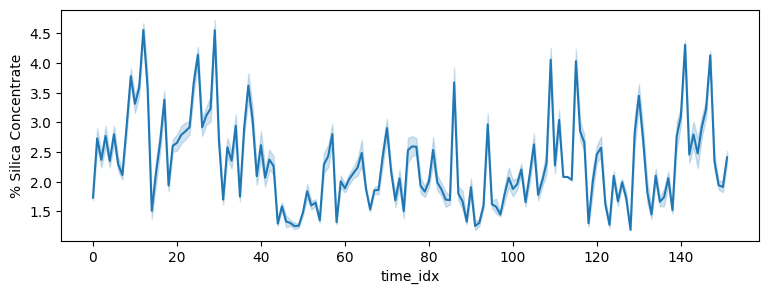

In [69]:
fig, ax = plt.subplots(figsize=(9, 3))
sns.lineplot(x = "time_idx", y = "% Silica Concentrate", data = data, ax=ax)
plt.show()

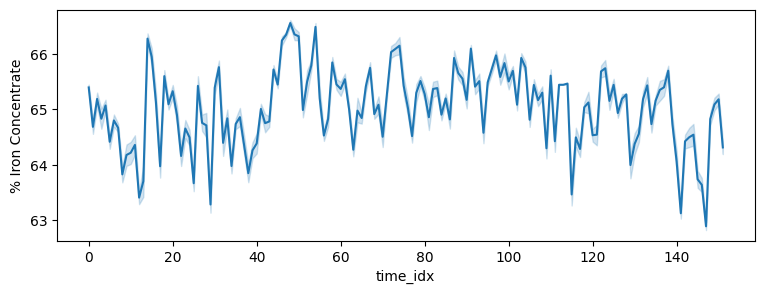

In [419]:
fig, ax = plt.subplots(figsize=(9, 3))
sns.lineplot(x = "time_idx", y = "% Iron Concentrate", data = data, ax=ax)
plt.show()

In [10]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

In [11]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="% Silica Concentrate",
    group_ids=['time_range'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["year"],
    static_reals=[],
    time_varying_known_categoricals=["time_range"],
    variable_groups={"time_range": time_range},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['% Iron Feed', '% Silica Feed', "time_idx", "hour"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
        "% Iron Concentrate", "% Silica Concentrate"
    ],
    target_normalizer=GroupNormalizer(
        groups=['time_range'], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Create baseline model


In [17]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

2023-06-10 11:48:51.468844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 11:48:52.407477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
baseline_predictions.y[0]

tensor([[1.8400, 1.8400, 1.8400, 1.8400, 1.8400, 4.1800],
        [1.3300, 1.3300, 1.3300, 1.3300, 1.3300, 3.1200],
        [1.5700, 1.5700, 1.5700, 1.5700, 1.5700, 2.1500]])

In [19]:
mae = torch.mean(torch.abs(baseline_predictions.output - baseline_predictions.y[0]))
mae

tensor(0.2617)

## Train the Temporal Fusion Transformer


### Find optimal learning rate


Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).


In [10]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.15,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 16.5k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.07943282347242808
Restoring states from the checkpoint path at /home/slcf/project/pytorch-forecasting/.lr_find_43ee3656-347c-44ac-ac87-7c559a1df9ed.ckpt
Restored all states from the checkpoint at /home/slcf/project/pytorch-forecasting/.lr_find_43ee3656-347c-44ac-ac87-7c559a1df9ed.ckpt


suggested learning rate: 0.07943282347242808


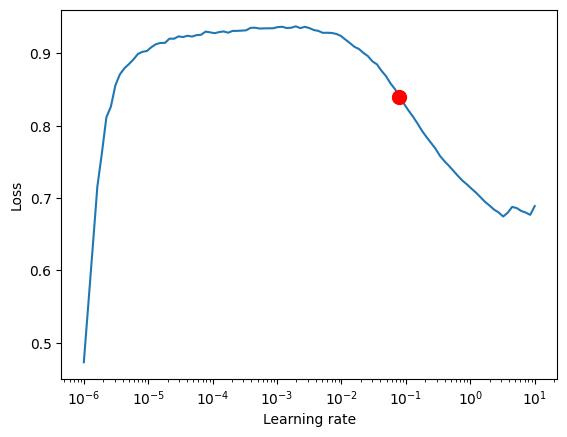

In [271]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model


If you have troubles training the model and get an error `AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'`, consider either uninstalling tensorflow or first execute

````
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```.
````


In [11]:
import tensorflow as tf
import tensorboard as tb

2023-06-10 11:53:12.685744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 11:53:13.706135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# configure network and trainer
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=30, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.07,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=0,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

tft.to(device)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 35.5k


TemporalFusionTransformer(
  	"attention_head_size":               2
  	"categorical_groups":                {'time_range': ['dawn', 'day', 'night']}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {'time_range': {'-': 0, 'dawn': 1, 'day': 2, 'night': 3}}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {'time_range': (4, 3)}
  	"hidden_continuous_size":            8
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       16
  	"learning_rate":                     0.07
  	"log_gradient_flow":                 False
  	"log_interval":                      0
  	"log_val_interval":                  0
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"lstm_layers":        

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [26]:
!nvidia-smi

Sat Jun 10 11:51:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   30C    P8     8W / 250W |      2MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN X ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   

Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.


In [14]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 12    
3  | prescalers                         | ModuleDict                      | 448   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 16.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Hyperparameter tuning

In [366]:
# import pickle
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open(path+"test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

## Evaluate performance


PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.


In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [24]:
predictions.output

tensor([[1.8512, 1.8669, 1.8698, 1.8637, 1.8493, 1.2576],
        [1.3751, 1.3750, 1.3828, 1.3893, 1.3928, 4.0657],
        [1.5409, 1.5522, 1.5731, 1.5785, 1.5710, 1.2165]])

In [23]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(0.2904)

In [25]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

In [414]:
raw_predictions.x

{'encoder_cat': tensor([[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          ...,
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
 
         [[0, 2, 0],
          [0, 2, 0],
          [0, 2, 0],
          ...,
          [0, 2, 0],
          [0, 2, 0],
          [0, 2, 0]],
 
         [[0, 0, 3],
          [0, 0, 3],
          [0, 0, 3],
          ...,
          [0, 0, 3],
          [0, 0, 3],
          [0, 0, 3]]]),
 'encoder_cont': tensor([[[-1.3720e+00,  1.4818e+00,  1.1458e+02,  ..., -9.1285e-01,
            1.2730e+00, -1.2130e+00],
          [-1.3720e+00,  1.4818e+00,  1.1458e+02,  ..., -9.2967e-01,
            1.2730e+00, -1.2130e+00],
          [-1.3720e+00,  1.4818e+00,  1.1458e+02,  ..., -9.2135e-01,
            1.2730e+00, -1.2130e+00],
          ...,
          [ 5.8496e-01, -1.0096e+00,  1.1458e+02,  ..., -2.5155e-01,
            2.7536e-02, -7.3861e-02],
          [ 5.8496e-01, -1.0096e+00,  1.1458e+02,  ..., -2.9151e-01,
            2.7536e-02, -

In [413]:
raw_predictions.output.prediction

tensor([[[1.4852, 1.7958, 1.8296, 1.8495, 1.8856, 1.8804, 2.1695],
         [1.4776, 1.7913, 1.8316, 1.8527, 1.8881, 1.8977, 2.2057],
         [1.4672, 1.7817, 1.8303, 1.8541, 1.8910, 1.9176, 2.2479],
         [1.4523, 1.7647, 1.8236, 1.8525, 1.8939, 1.9412, 2.2938],
         [1.4307, 1.7334, 1.8062, 1.8452, 1.8972, 1.9741, 2.3490],
         [0.8639, 1.0400, 1.2520, 1.5566, 1.9744, 2.7294, 4.0689]],

        [[1.2421, 1.2770, 1.2995, 1.3207, 1.3431, 1.3644, 1.5264],
         [1.2327, 1.2700, 1.2896, 1.3115, 1.3371, 1.3689, 1.5323],
         [1.2293, 1.2673, 1.2868, 1.3082, 1.3369, 1.3681, 1.5227],
         [1.2293, 1.2704, 1.2900, 1.3121, 1.3443, 1.3812, 1.5353],
         [1.2246, 1.2719, 1.2925, 1.3177, 1.3556, 1.4046, 1.5640],
         [0.9258, 1.0144, 1.1784, 1.5038, 1.9868, 2.8277, 4.1761]],

        [[1.3874, 1.4917, 1.5076, 1.5240, 1.5509, 1.5440, 1.7323],
         [1.3762, 1.4727, 1.4900, 1.5079, 1.5356, 1.5504, 1.7521],
         [1.3586, 1.4495, 1.4710, 1.4933, 1.5258, 1.5626, 

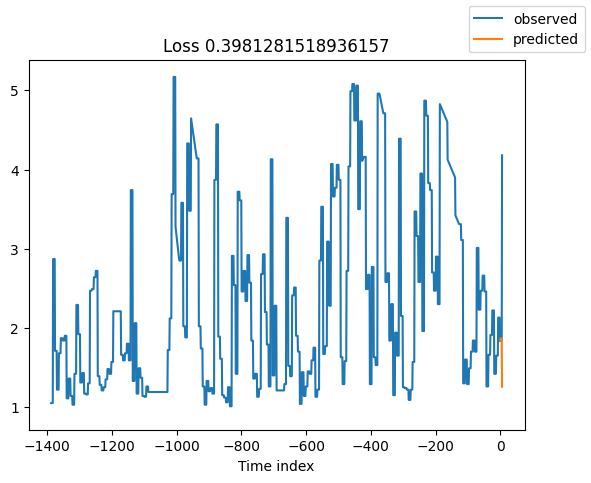

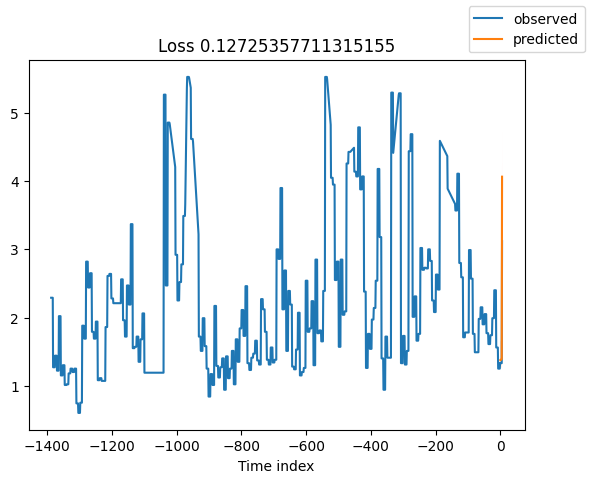

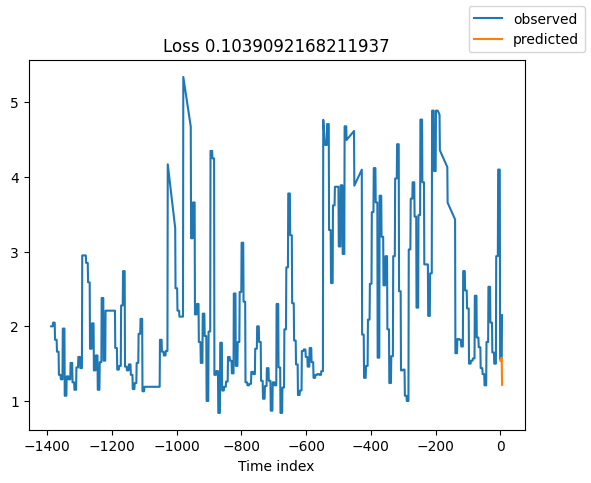

In [26]:
for idx in range(3):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx, add_loss_to_title=True ,plot_attention = False)

In [367]:
raw_predictions.output

Output(prediction=tensor([[[1.4852, 1.7958, 1.8296, 1.8495, 1.8856, 1.8804, 2.1695],
         [1.4776, 1.7913, 1.8316, 1.8527, 1.8881, 1.8977, 2.2057],
         [1.4672, 1.7817, 1.8303, 1.8541, 1.8910, 1.9176, 2.2479],
         [1.4523, 1.7647, 1.8236, 1.8525, 1.8939, 1.9412, 2.2938],
         [1.4307, 1.7334, 1.8062, 1.8452, 1.8972, 1.9741, 2.3490],
         [0.8639, 1.0400, 1.2520, 1.5566, 1.9744, 2.7294, 4.0689]],

        [[1.2421, 1.2770, 1.2995, 1.3207, 1.3431, 1.3644, 1.5264],
         [1.2327, 1.2700, 1.2896, 1.3115, 1.3371, 1.3689, 1.5323],
         [1.2293, 1.2673, 1.2868, 1.3082, 1.3369, 1.3681, 1.5227],
         [1.2293, 1.2704, 1.2900, 1.3121, 1.3443, 1.3812, 1.5353],
         [1.2246, 1.2719, 1.2925, 1.3177, 1.3556, 1.4046, 1.5640],
         [0.9258, 1.0144, 1.1784, 1.5038, 1.9868, 2.8277, 4.1761]],

        [[1.3874, 1.4917, 1.5076, 1.5240, 1.5509, 1.5440, 1.7323],
         [1.3762, 1.4727, 1.4900, 1.5079, 1.5356, 1.5504, 1.7521],
         [1.3586, 1.4495, 1.4710, 1.4933

### Worst performers

In [141]:
# # calcualte metric by which to display
# predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
# mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
# indices = mean_losses.argsort(descending=True)  # sort losses
# for idx in range(1):  # plot 10 examples
#     best_tft.plot_prediction(
#         raw_predictions.x,
#         raw_predictions.output,
#         idx=indices[idx],
#         add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
#     )

### Actuals vs predictions by variables


{'% Iron Feed': <Figure size 1000x500 with 2 Axes>,
 '% Silica Feed': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 '% Silica Concentrate_center': <Figure size 1000x500 with 2 Axes>,
 '% Silica Concentrate_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'hour': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Starch Flow': <Figure size 1000x500 with 2 Axes>,
 'Amina Flow': <Figure size 1000x500 with 2 Axes>,
 'Ore Pulp Flow': <Figure size 1000x500 with 2 Axes>,
 'Ore Pulp pH': <Figure size 1000x500 with 2 Axes>,
 'Ore Pulp Density': <Figure size 1000x500 with 2 Axes>,
 'Flotation Column 01 Air Flow': <Figure size 1000x500 with 2 Axes>,
 'Flotation Column 02 Air Flow': <Figure size 1000x500 with 2 Axes>,
 'Flotation Column 03 Air Flow': <Figure size 1000x500 with 2 Axes>,
 'Flotation Column 04 Air Flow': <Figure size 1000x500 with 2 Axes>,
 'Flotatio

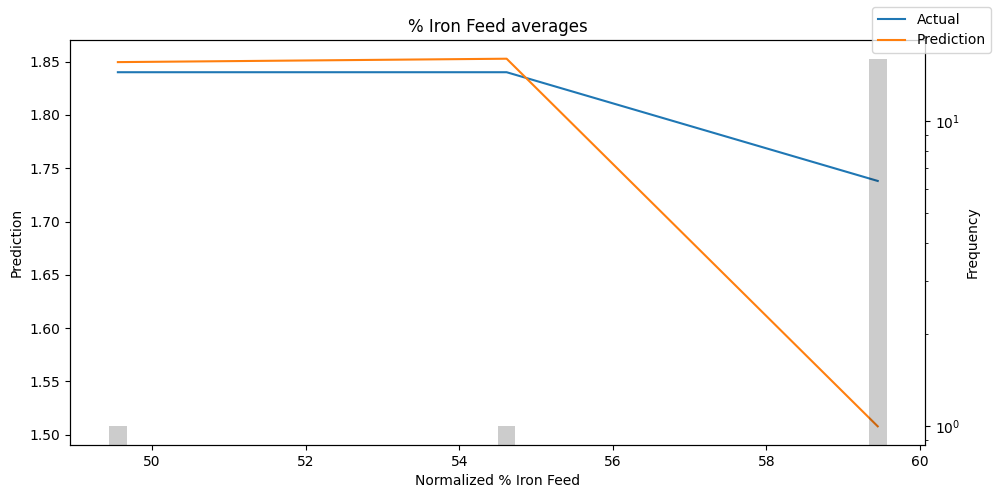

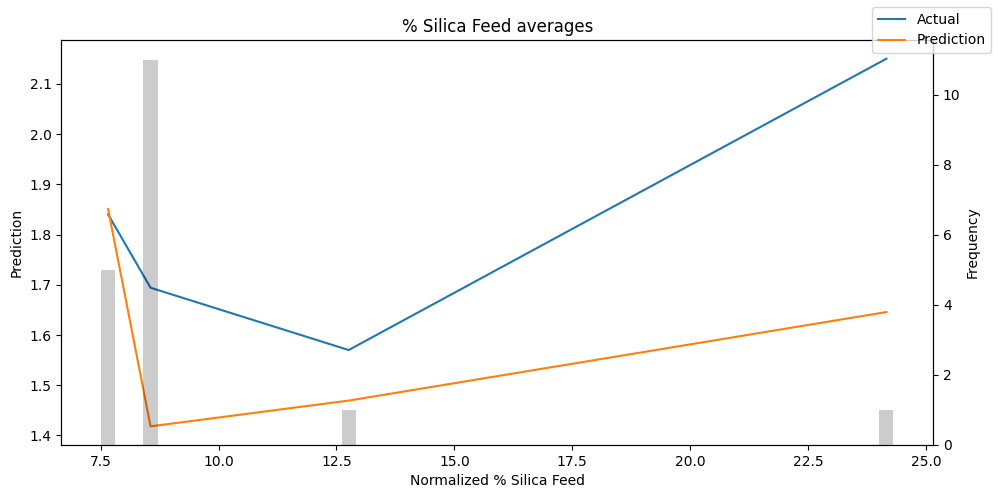

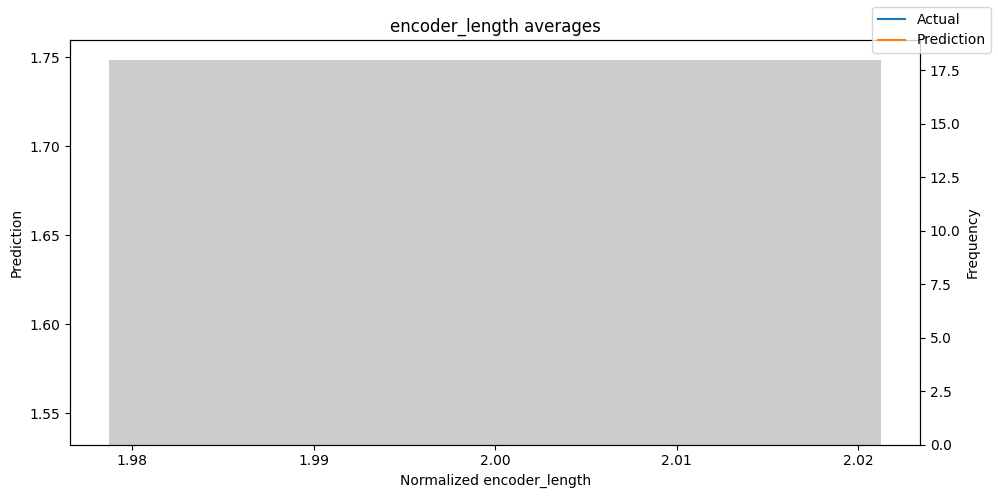

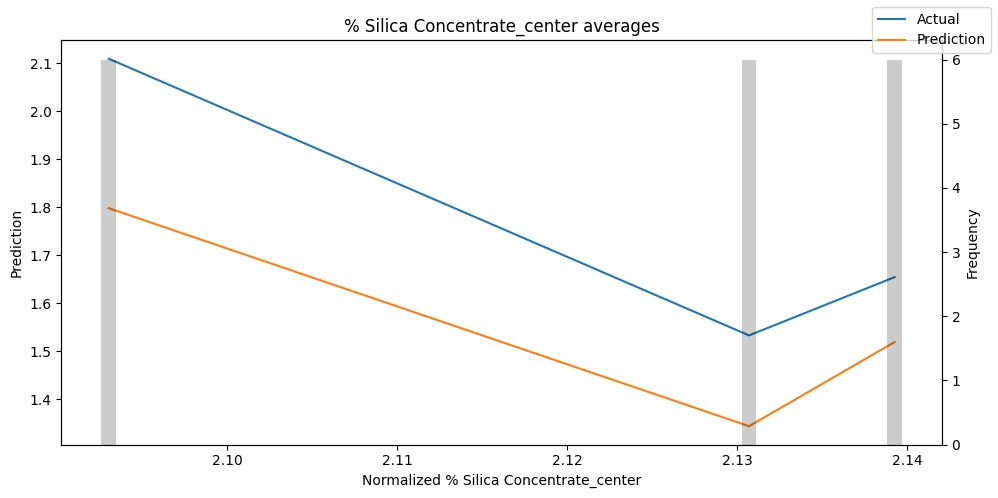

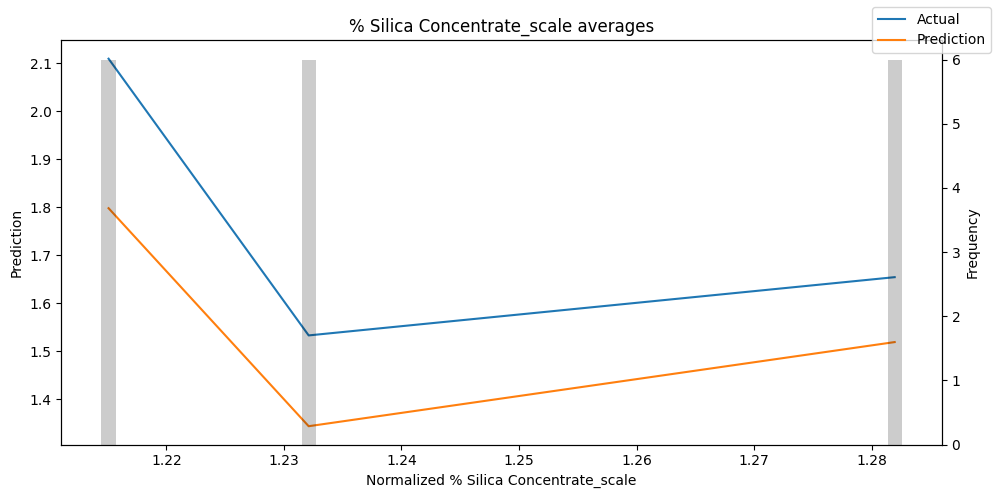

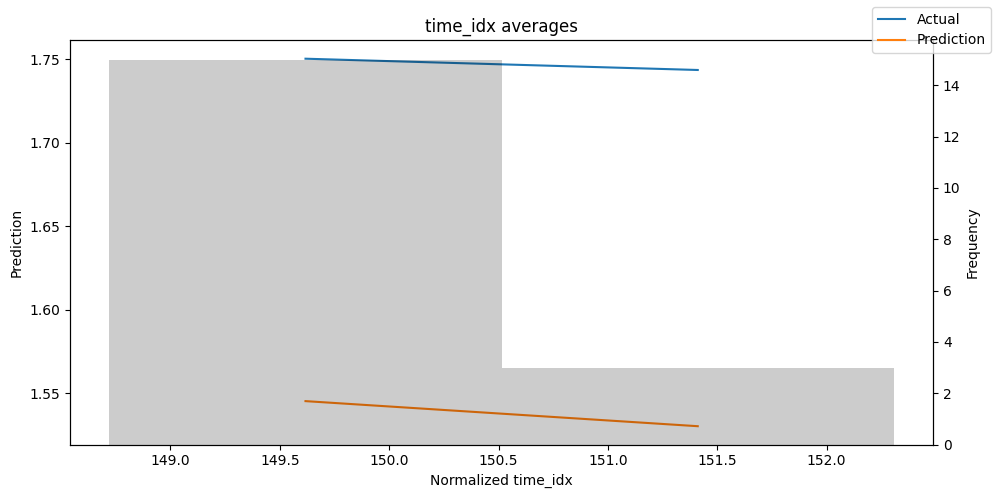

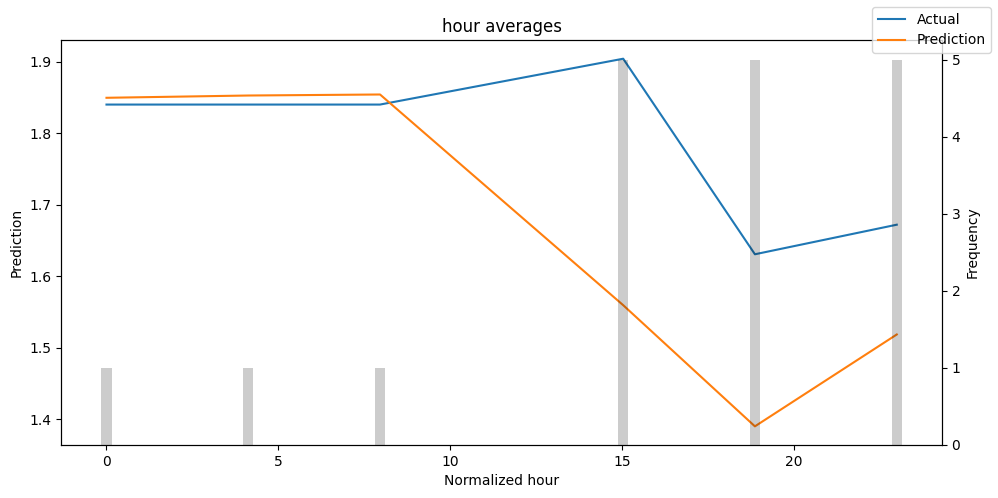

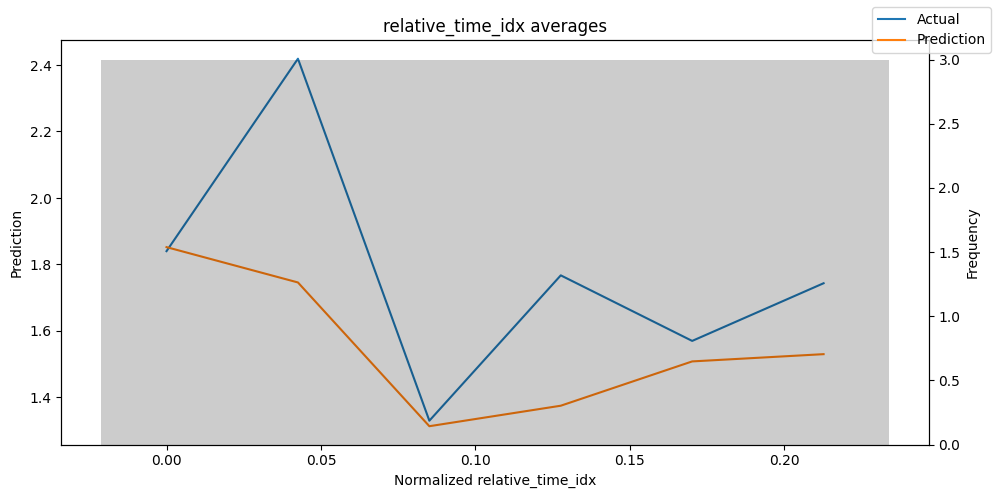

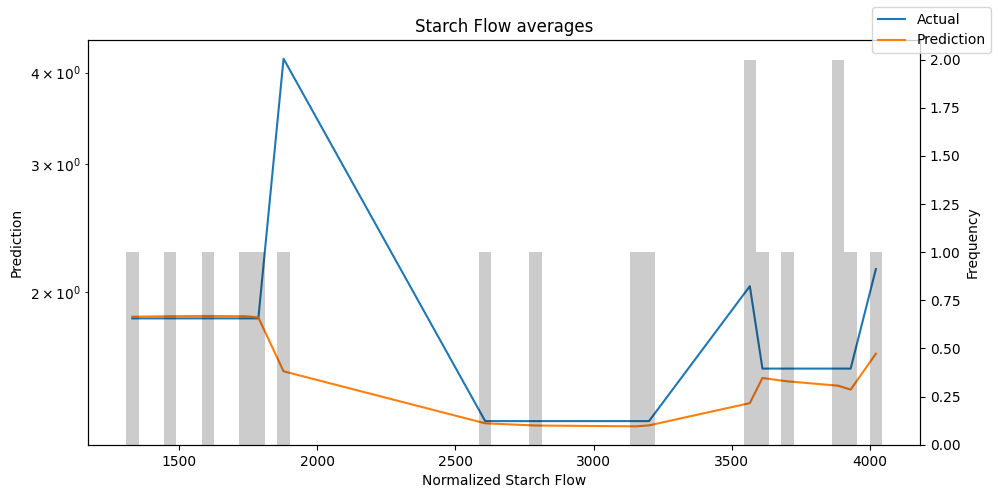

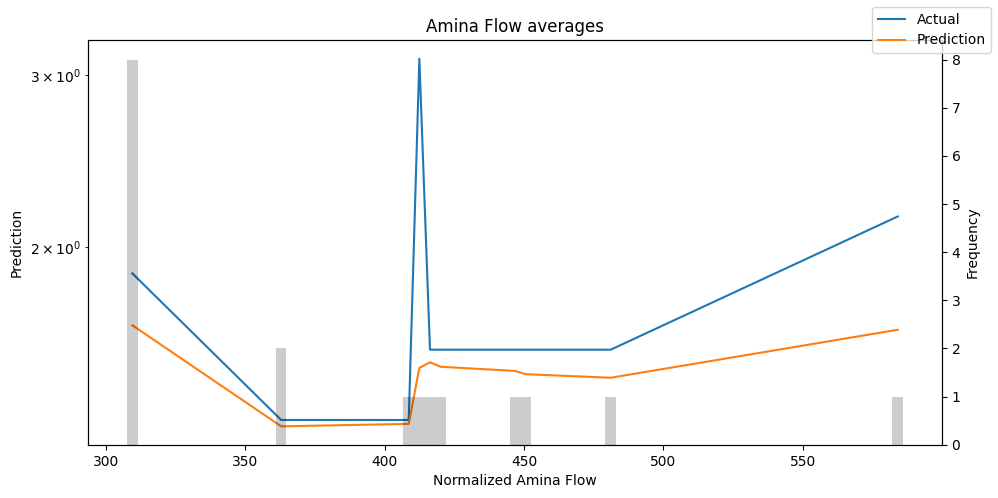

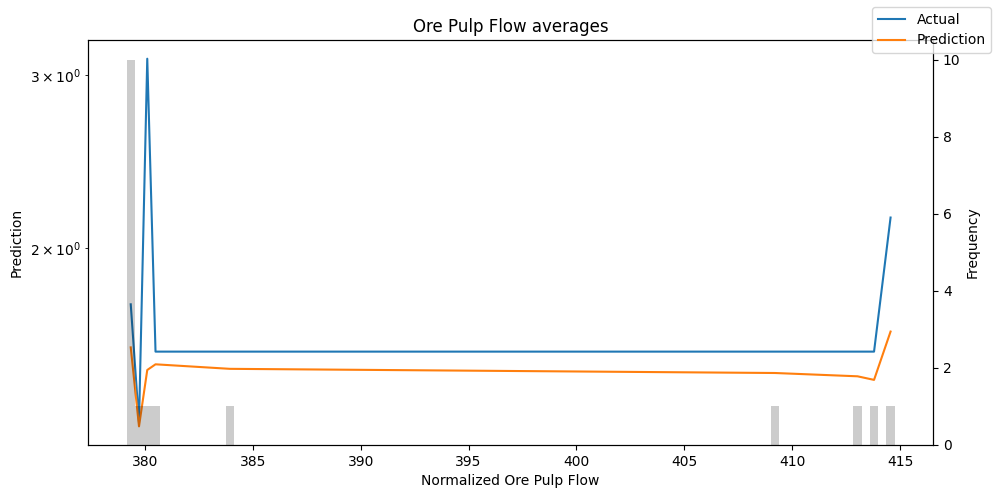

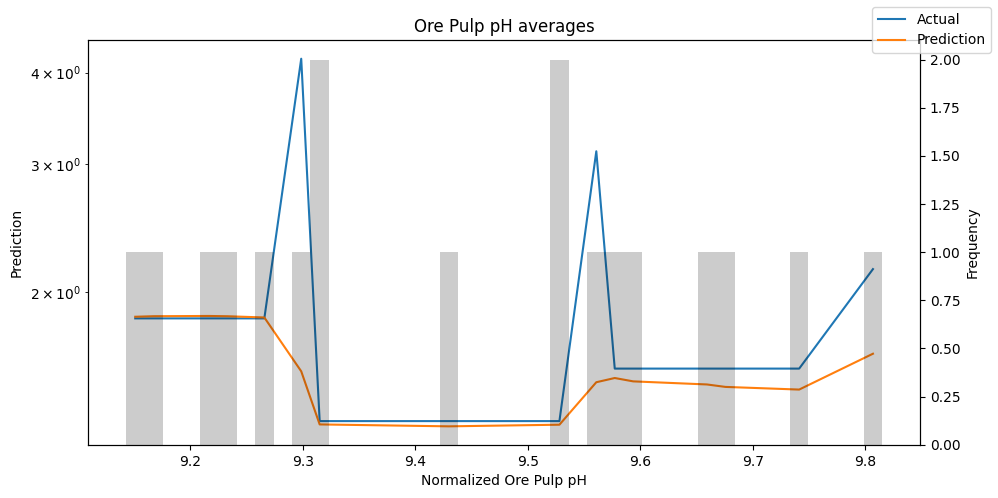

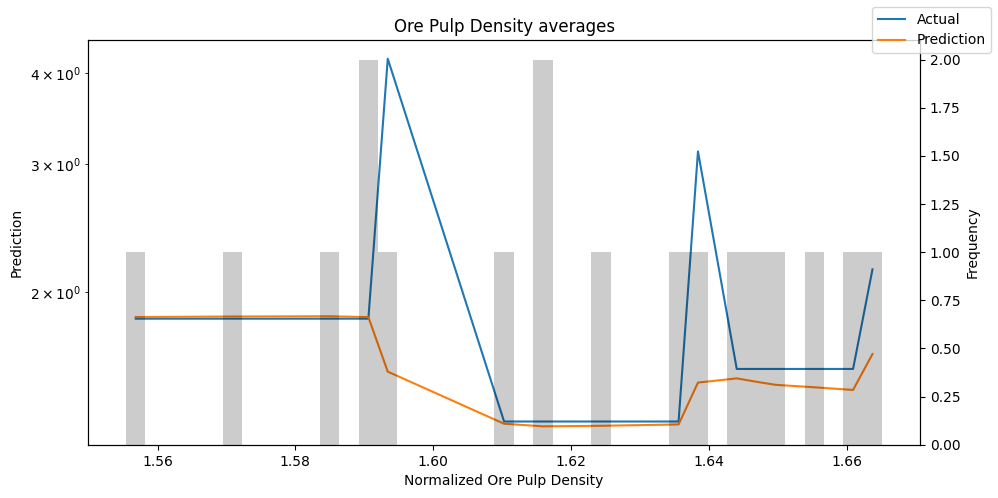

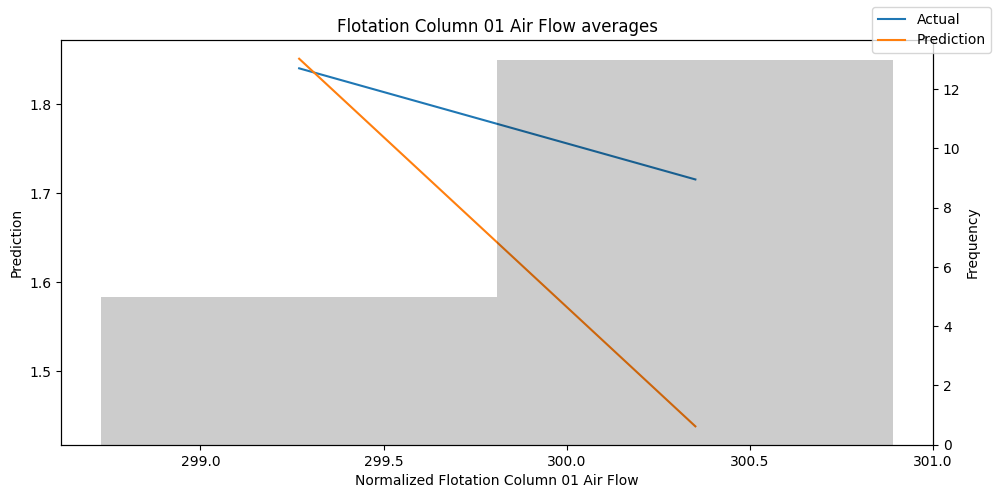

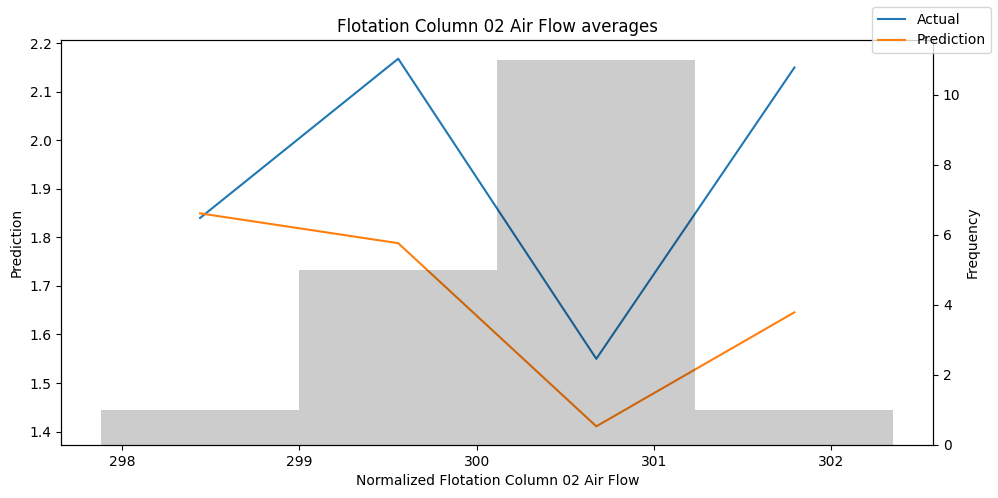

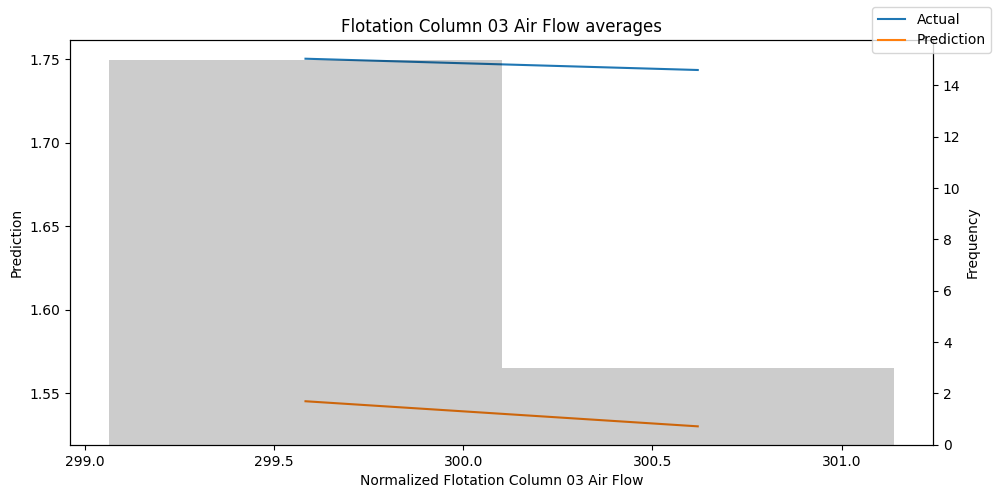

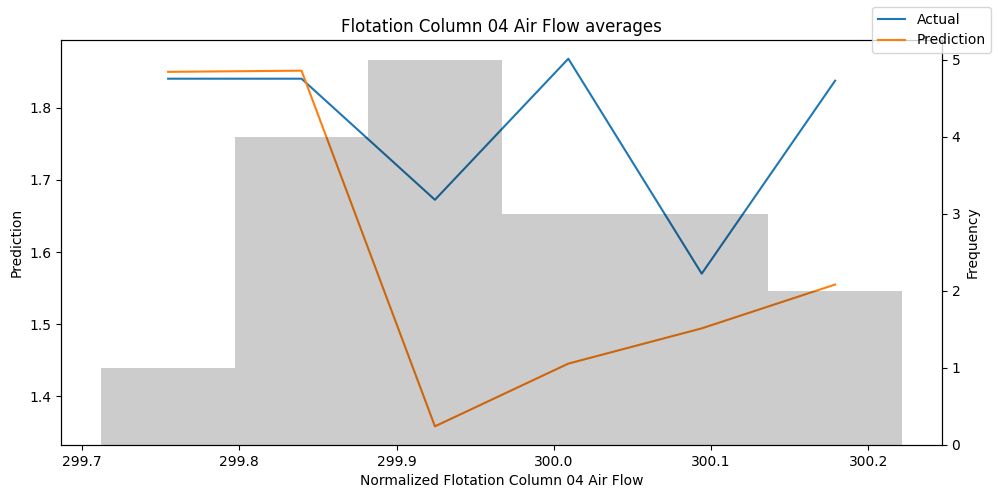

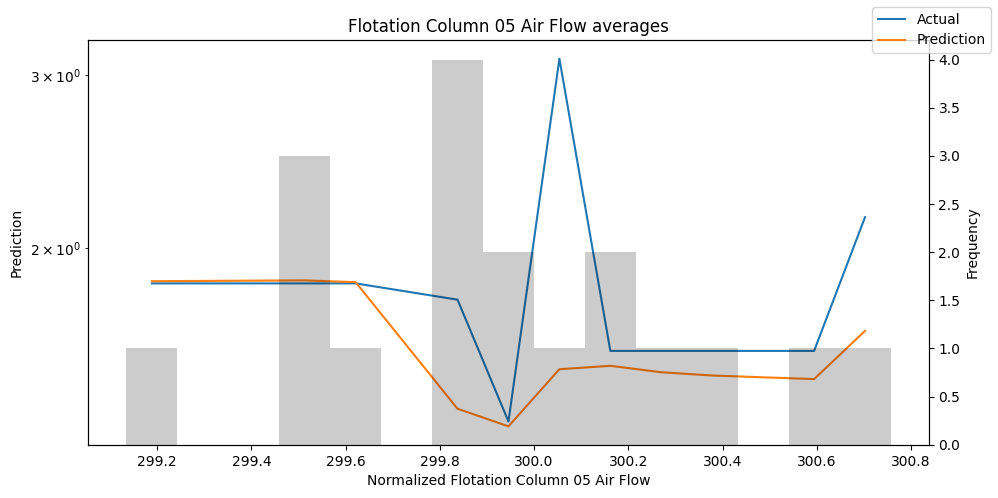

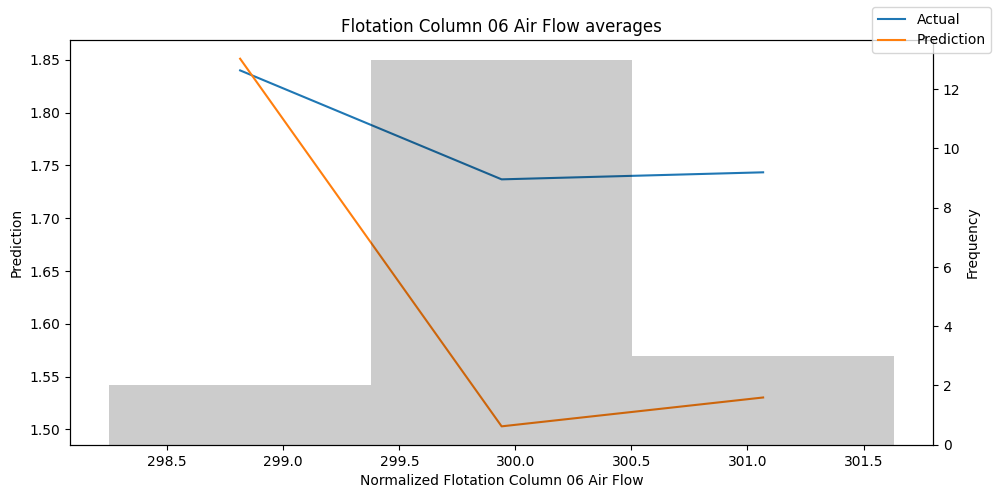

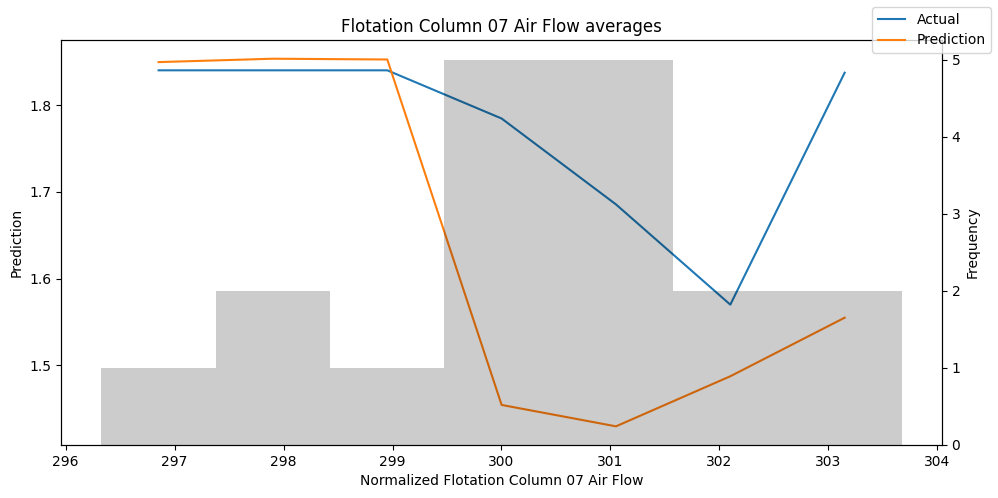

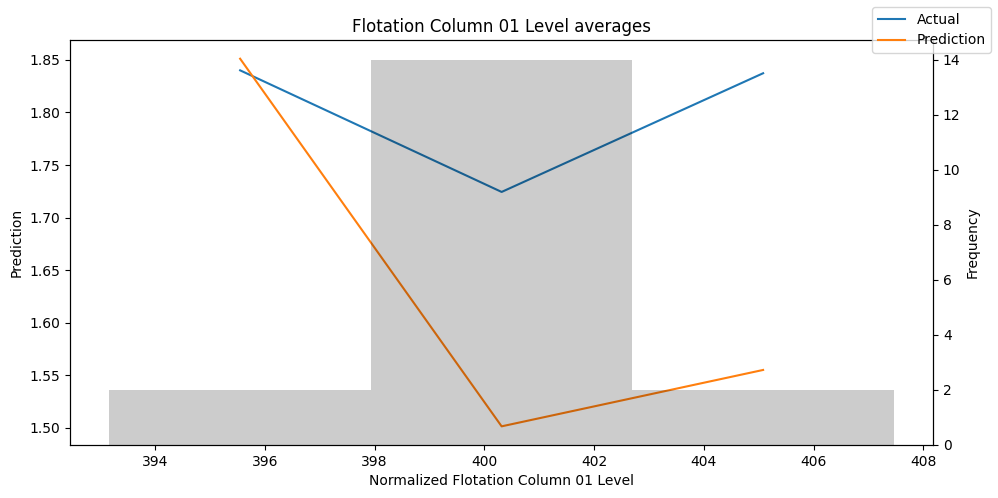

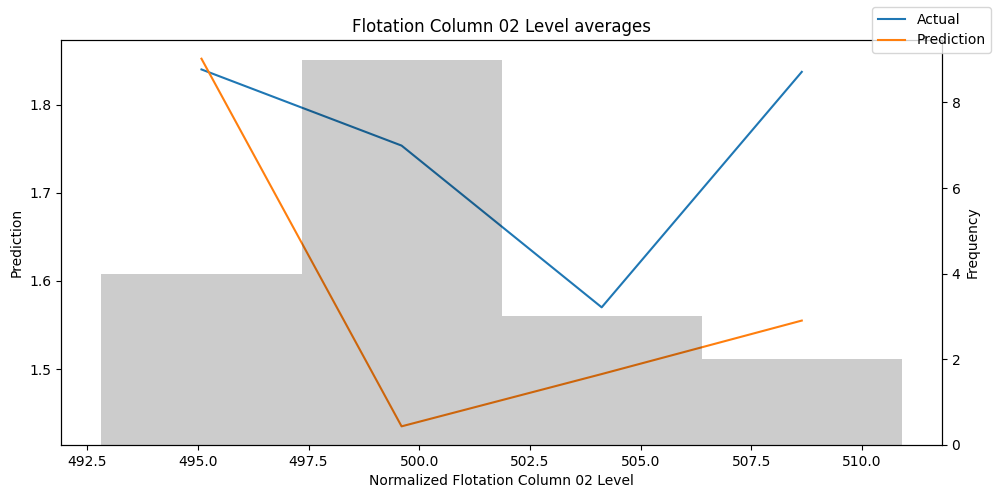

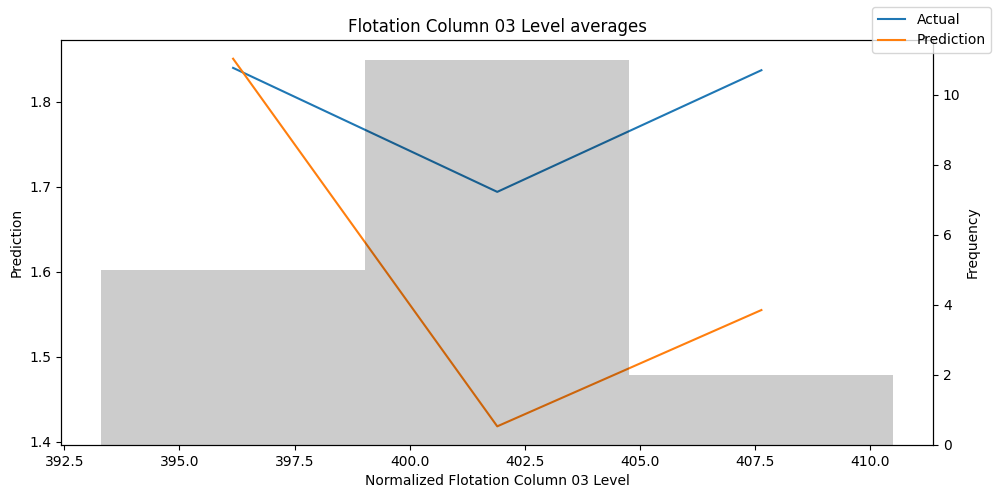

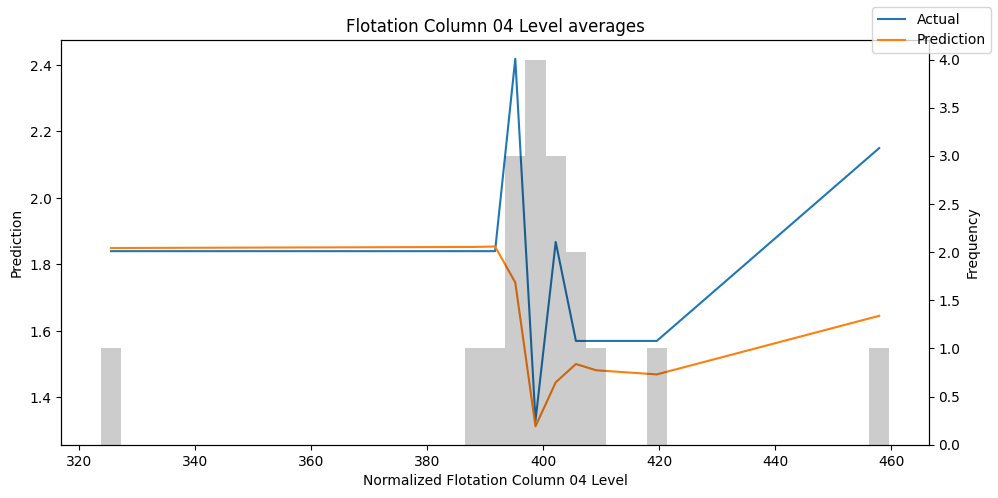

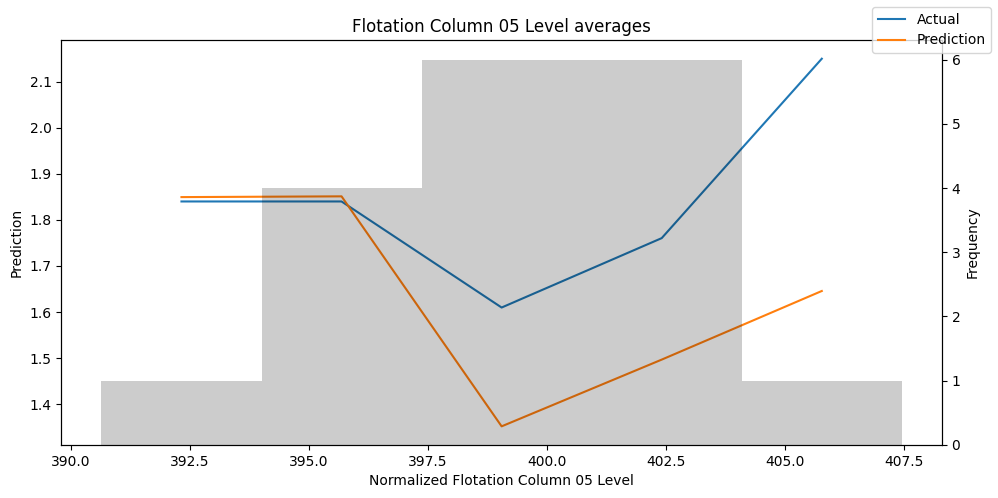

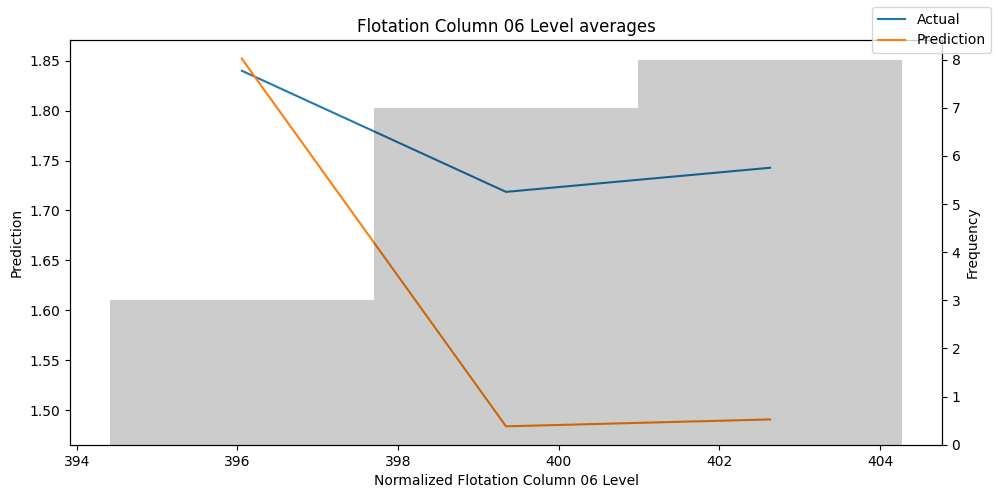

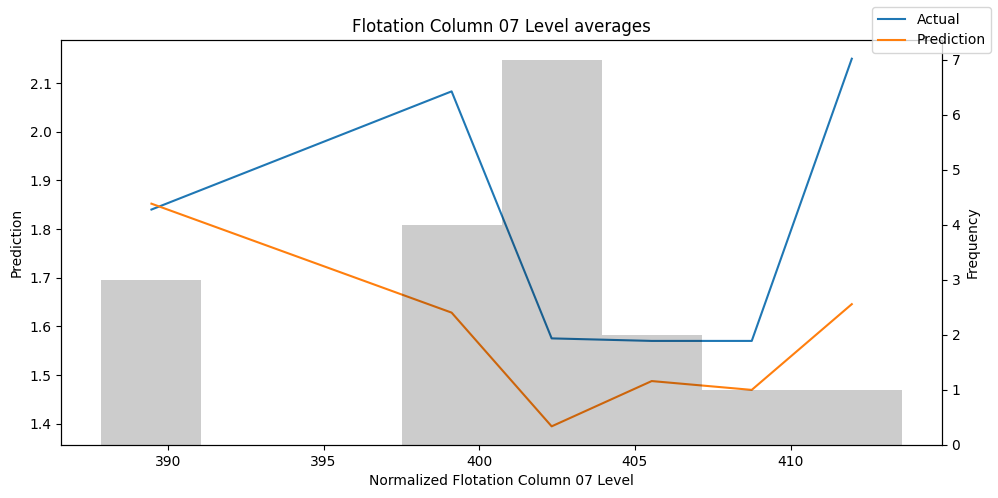

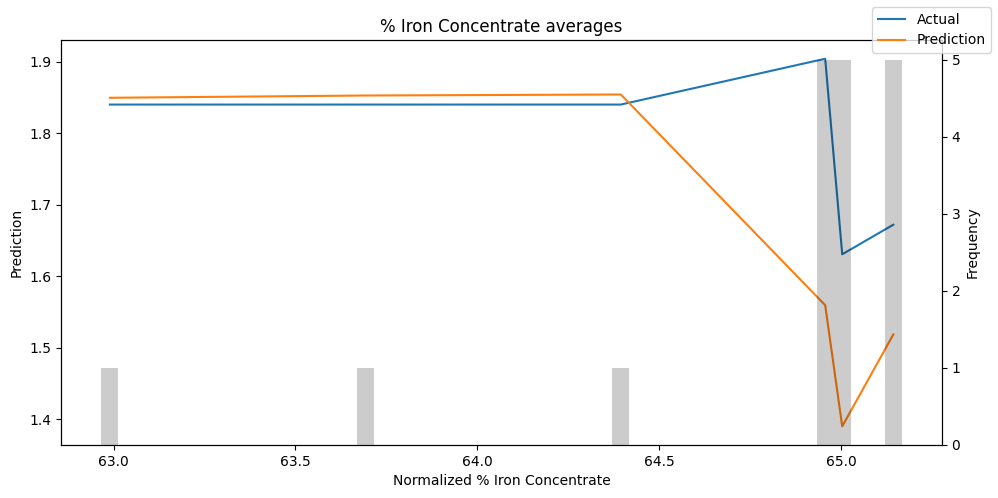

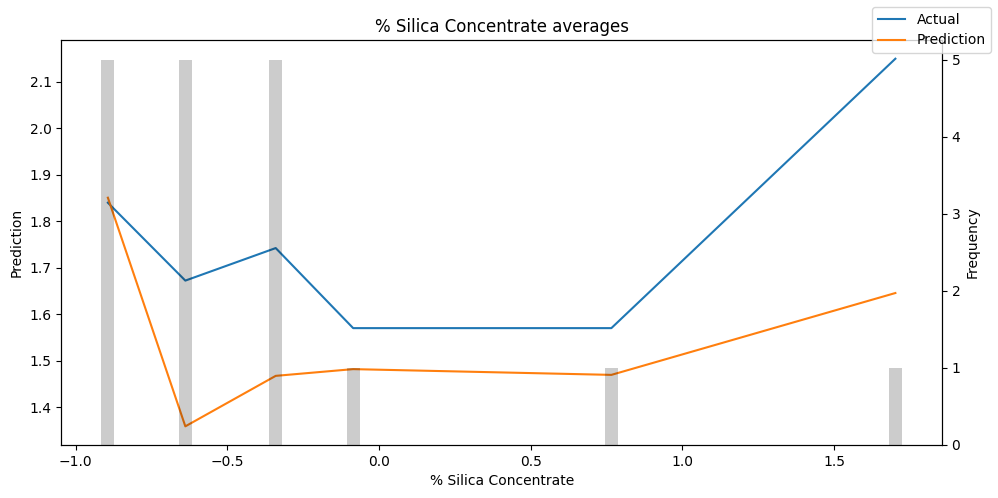

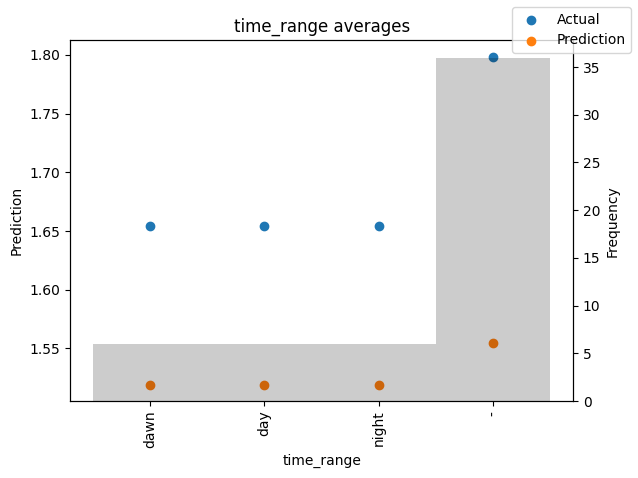

In [280]:
predictions = best_tft.predict(val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Predict on selected data


Of course, we can also plot this prediction readily:


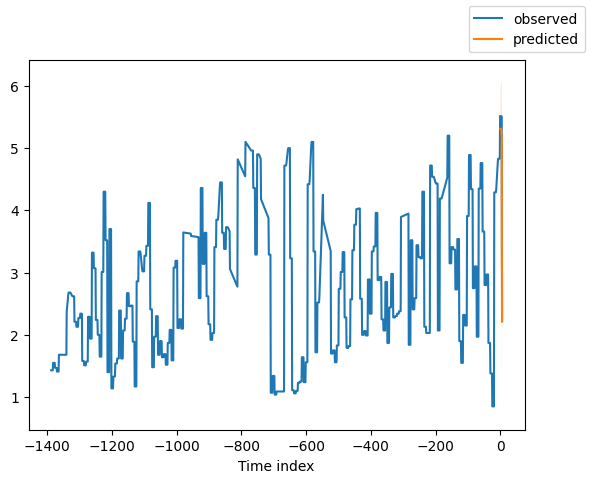

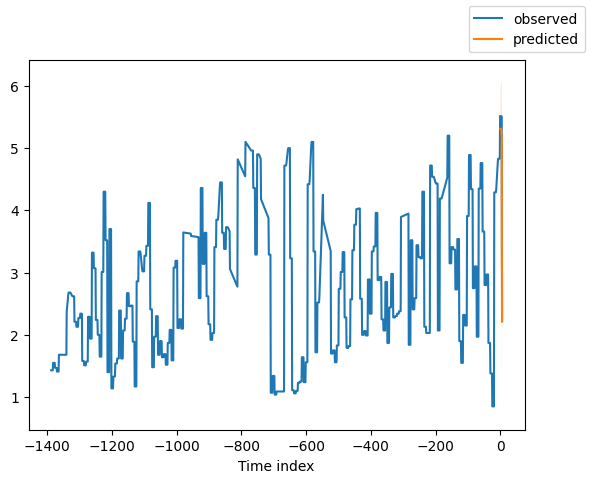

In [409]:
raw_prediction = best_tft.predict(
    training.filter(lambda x: (x['time_range'] == 'dawn')),
    mode="raw",
    return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, plot_attention=False)

## Predict on new data


Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.


In [27]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(time_idx=lambda x: x.time_idx + i) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [28]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

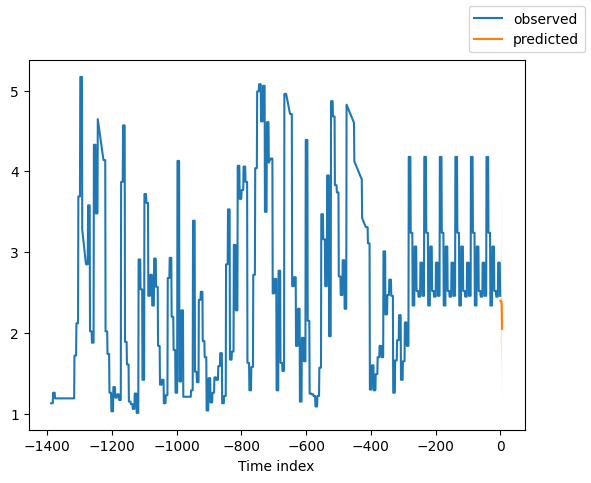

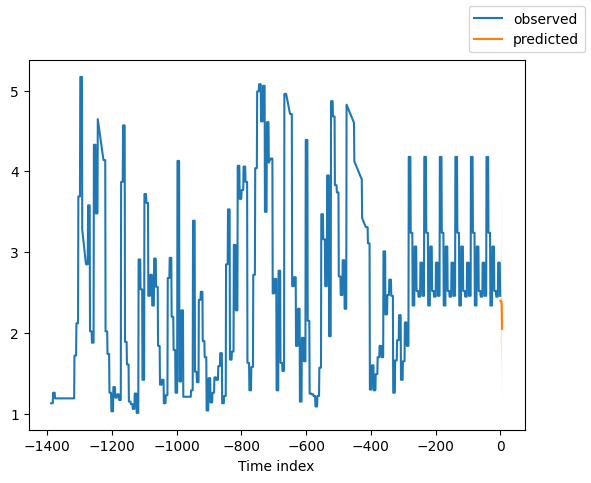

In [29]:
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False, plot_attention = False)

## Interpret model


### Variable importances


In [31]:
best_tft.encoder_variables

['time_range',
 'time_idx',
 'hour',
 'relative_time_idx',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 02 Air Flow',
 'Flotation Column 03 Air Flow',
 'Flotation Column 04 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 07 Air Flow',
 'Flotation Column 01 Level',
 'Flotation Column 02 Level',
 'Flotation Column 03 Level',
 'Flotation Column 04 Level',
 'Flotation Column 05 Level',
 'Flotation Column 06 Level',
 'Flotation Column 07 Level',
 '% Silica Concentrate']

In [19]:
def plot_interpretation(interpretation):
        """
        Make figures that interpret model.

        * Attention
        * Variable selection weights / importances

        Args:
            interpretation: as obtained from ``interpret_output()``

        Returns:
            dictionary of matplotlib figures
        """
        figs = {}

        # attention
        fig, ax = plt.subplots()
        attention = interpretation["attention"].detach().cpu()
        attention = attention / attention.sum(-1).unsqueeze(-1)
        ax.plot(
            np.arange(-best_tft.hparams.max_encoder_length, attention.size(0) - best_tft.hparams.max_encoder_length), attention
        )
        ax.set_xlabel("Time index")
        ax.set_ylabel("Attention")
        ax.set_title("Attention")
        figs["attention"] = fig

        # variable selection
        def make_selection_plot(title, values, labels):
            fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
            order = np.argsort(values)
            values = values / values.sum(-1).unsqueeze(-1)
            ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
            ax.set_title(title)
            ax.set_xlabel("Importance in %")
            plt.tight_layout()
            return fig

        figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), best_tft.static_variables
        )
        figs["encoder_variables"] = make_selection_plot(
            "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), best_tft.encoder_variables
        )
        figs["decoder_variables"] = make_selection_plot(
            "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), best_tft.decoder_variables
        )

        return figs

In [23]:
def make_selection_plot(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum(-1).unsqueeze(-1)
    ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
    ax.set_title(title)
    ax.set_xlabel("Importance in %")
    plt.tight_layout()
    return fig

In [20]:
import torch

In [21]:
interpretation = {'attention': torch.tensor([13.7767, 15.3985, 16.8256, 18.2374, 18.3187, 13.0428, 20.4714, 18.5408,
         13.2350, 12.6215, 11.8816, 12.6967, 12.7385, 12.8461, 13.8678, 15.2382,
         15.3900, 10.9702, 17.3647, 16.2130, 12.5573, 12.3048, 12.6885, 12.7743]),
 'static_variables': torch.tensor([ 46.9361,  40.4601,  72.2863,  63.1314,  10.5714,  16.5426, 100.0721]),
 'encoder_variables': torch.tensor([  2.6334,   4.6224,   5.0999,   5.6506,   4.7039,   4.7906, 293.3669,
           4.7976,   4.6914,   5.0228,   4.8483,   4.8471,   4.9249]),
 'decoder_variables': torch.tensor([33.8799,  3.8803, 68.6542, 70.2373, 93.5663, 79.7821]),
 'encoder_length_histogram': torch.tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 350]),
 'decoder_length_histogram': torch.tensor([  0,   0,   0,   0,   0, 350])}

In [2]:
#interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
#best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.


### Partial dependency
- 왠지모르겠는데 에러남.

In [30]:
# dependency = best_tft.predict_dependency(
#     val_dataloader.datdaset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe")

In [ ]:
# # plotting median and 25% and 75% percentile
# agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
#     median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
# )
# ax = agg_dependency.plot(y="median")
# ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)